In [1]:
from gwsdp.generate_dataset import generate_sample_preturb
from ggw import gw_global
import numpy as np
import itertools as it
from ot.gromov import gromov_wasserstein
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def compute_gw(transport_plan, C1, C2, method="vectorized"):
    n = len(C1)
    assert len(C1) == len(C2)
    if method == "uniform-einsum":
        return ((np.ones((n, n)) / n**2) * (C1**2 + C2**2)).sum() - 2 * np.einsum(
            "ij,kl,ik,jl->", C1, C2, transport_plan, transport_plan
        )
    elif method == "vectorized":
        mu_x = transport_plan.sum(1)
        mu_x_out = np.outer(mu_x, mu_x)
        mu_y = transport_plan.sum(0)
        mu_y_out = np.outer(mu_y, mu_y)
        diag = (mu_x_out * C1**2).sum() + (mu_y_out * C2**2).sum()
        cross = -2 * np.sum((C1 @ transport_plan) * (transport_plan @ C2))
        return diag + cross

    elif method == "naive-loop":
        obj = 0
        for i, j, k, el in it.product(range(n), range(n), range(n), range(n)):
            obj += (
                (C1[i, j] - C2[k, el]) ** 2
                * transport_plan[i, k]
                * transport_plan[j, el]
            )
        return obj
    else:
        raise ValueError("method not recognized")


def rel_error(pred, gt):
    if pred < gt:
        print("gt min not optimal")
    return np.linalg.norm(pred - gt) / np.linalg.norm(gt)

In [54]:
np.random.seed(0)

n = 10
C1, C2, p, q, X, Y = generate_sample_preturb(n=n, scale=0.01, dim=2)

In [55]:
pred_t = compute_gw(np.eye(n) / n, C1, C2)
pred_f = compute_gw(np.eye(n) / n, C1, C2, "vectorized")
pred_t, pred_t - pred_f

(np.float64(0.00026263301333528943), np.float64(0.0))

Text(0.5, 1.0, 'GT | min=2.63e-04')

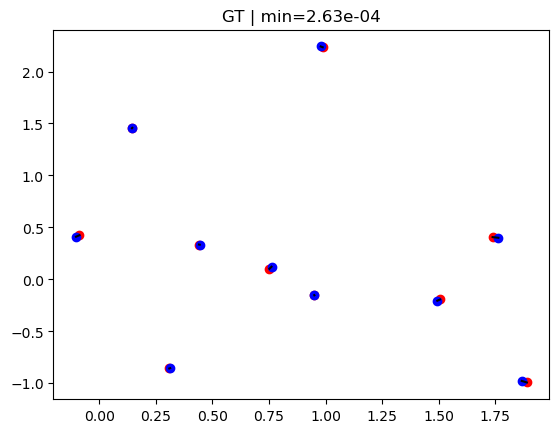

In [56]:
plt.plot(X[:, 0], X[:, 1], "ro")
plt.plot(Y[:, 0], Y[:, 1], "bo")
# black lines indicate the matching
for i in range(n):
    plt.plot([X[i, 0], Y[i, 0]], [X[i, 1], Y[i, 1]], "k-")
gt = compute_gw(np.eye(n) / n, C1, C2, "vectorized")
plt.title("GT | min={:.2e}".format(gt))

In [6]:
p = 10 * n + np.arange(n)
p = p / p.sum()
q = p  # [::-1]
# p = q = None

T, log = gromov_wasserstein(
    C1,
    C2,
    p=p,
    q=q,
    loss_fun="square_loss",
    symmetric=True,
    log=True,
    max_iter=1e4,
    tol_rel=1e-9,
    tol_abs=1e-9,
    verbose=True,
)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.722284e+00|0.000000e+00|0.000000e+00
    1|2.468397e-01|5.977339e+00|1.475445e+00
    2|1.780401e-04|1.385427e+03|2.466617e-01
    3|1.780401e-04|0.000000e+00|0.000000e+00


In [7]:
p

array([0.00952835, 0.00953788, 0.0095474 , 0.00955693, 0.00956646,
       0.00957599, 0.00958552, 0.00959505, 0.00960457, 0.0096141 ,
       0.00962363, 0.00963316, 0.00964269, 0.00965222, 0.00966174,
       0.00967127, 0.0096808 , 0.00969033, 0.00969986, 0.00970939,
       0.00971891, 0.00972844, 0.00973797, 0.0097475 , 0.00975703,
       0.00976656, 0.00977608, 0.00978561, 0.00979514, 0.00980467,
       0.0098142 , 0.00982373, 0.00983325, 0.00984278, 0.00985231,
       0.00986184, 0.00987137, 0.0098809 , 0.00989042, 0.00989995,
       0.00990948, 0.00991901, 0.00992854, 0.00993807, 0.00994759,
       0.00995712, 0.00996665, 0.00997618, 0.00998571, 0.00999524,
       0.01000476, 0.01001429, 0.01002382, 0.01003335, 0.01004288,
       0.01005241, 0.01006193, 0.01007146, 0.01008099, 0.01009052,
       0.01010005, 0.01010958, 0.0101191 , 0.01012863, 0.01013816,
       0.01014769, 0.01015722, 0.01016675, 0.01017627, 0.0101858 ,
       0.01019533, 0.01020486, 0.01021439, 0.01022392, 0.01023

In [8]:
np.isclose(T, np.eye(n) / n).all()

np.False_

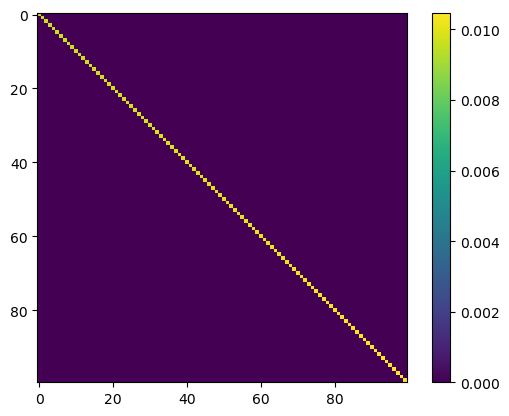

In [9]:
plt.imshow(T)
plt.colorbar()

In [10]:
pred = compute_gw(T, C1, C2, "vectorized").item()
pred

0.00017833709716796875

Text(0.5, 1.0, 'Local | min=1.78e-04 | err=4.12e-03')

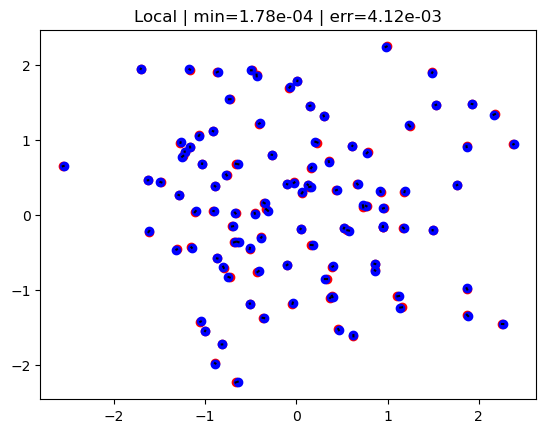

In [11]:
plt.plot(X[:, 0], X[:, 1], "ro")
plt.plot(Y[:, 0], Y[:, 1], "bo")

for i, j in it.product(range(n), range(n)):
    if T[i, j] > T.max() / 10:
        plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], "k-")
plt.title("Local | min={:1.2e} | err={:1.2e}".format(pred, rel_error(pred, gt)))

In [12]:
# from gwsdp.solvers import solve_gw_sdp
# pi, P, opt, prob = solve_gw_sdp(C1, C2, p, q, solver='SCS', max_iters=10000,
#                         verbose=True, tol=1e-5)
# compute_gw(pi, C1, C2)

In [13]:
# plt.plot(X[:,0], X[:,1], 'ro')
# plt.plot(Y[:,0], Y[:,1], 'bo')

# for i,j in it.product(range(n),range(n)):
#     if pi[i,j]>1e-6:
#         plt.plot([X[i,0], Y[j,0]], [X[i,1], Y[j,1]], 'k-')

In [14]:
P_ggw, logs = gw_global(X, Y, epsilon=1e-6, verbose=True, IterMax=1000, log=True)

Iter |Bound gap
----------------------
    0|8.742345e+04
    1|8.726179e+04
    2|8.720201e+04
    3|8.704035e+04
    4|8.500825e+04
    5|8.484659e+04
    6|8.478681e+04
    7|8.376592e+04
    8|8.360425e+04
    9|8.354448e+04
   10|8.135071e+04
   11|8.096761e+04
   12|7.705418e+04
   13|7.524968e+04
   14|7.340349e+04
   15|7.313364e+04
   16|8.229082e+03
   17|8.223621e+03
   18|7.590125e+03
   19|7.222982e+03
   20|6.780514e+03
   21|6.601073e+03
   22|6.355778e+03
   23|6.254612e+03
   24|6.011138e+03
   25|5.870368e+03
   26|5.573139e+03
   27|5.440940e+03
   28|5.439617e+03
   29|5.062899e+03
   30|5.060816e+03
   31|4.973666e+03
   32|4.946434e+03
   33|4.455882e+03
   34|4.443585e+03
   35|4.435972e+03
   36|4.001898e+03
   37|3.882879e+03
   38|3.842971e+03
   39|3.779185e+03
   40|3.734182e+03
   41|3.628878e+03
   42|3.518225e+03
   43|3.362219e+03
   44|3.340964e+03
   45|3.265238e+03
   46|2.948321e+03
   47|2.906843e+03
   48|2.871834e+03
   49|2.715899e+03
   50|2.694

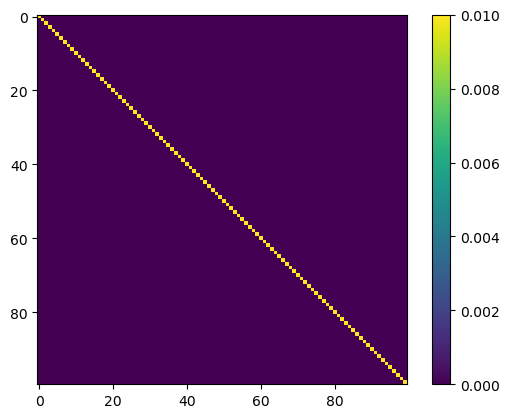

In [15]:
plt.imshow(P_ggw)
plt.colorbar()

In [16]:
obj = compute_gw(P_ggw, C1, C2, "vectorized")
obj

np.float64(0.00017760452404402827)

Text(0.5, 1.0, 'Local | min=1.78e-04 | err=0.00e+00')

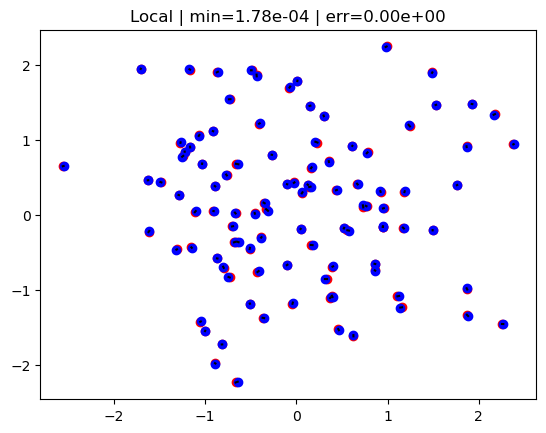

In [17]:
plt.plot(X[:, 0], X[:, 1], "ro")
plt.plot(Y[:, 0], Y[:, 1], "bo")

for i, j in it.product(range(n), range(n)):
    if P_ggw[i, j] > 1e-6:
        plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], "k-")
obj = compute_gw(P_ggw, C1, C2, "vectorized")

plt.title("Local | min={:1.2e} | err={:1.2e}".format(obj, rel_error(obj, gt)))

In [46]:
P_ggw, logs = gw_global(
    X, Y, epsilon=1e-2, verbose=True, IterMax=1000, log=True, mu_x=p, mu_y=q
)

Iter |Bound gap
----------------------
    0|8.723620e+00
    1|8.697777e+00
    2|8.691760e+00
    3|8.665917e+00
    4|8.473327e+00
    5|8.447484e+00
    6|8.441467e+00
    7|8.356827e+00
    8|8.330984e+00
    9|8.324967e+00
   10|8.106534e+00
   11|8.048831e+00
   12|7.669621e+00
   13|7.478396e+00
   14|7.337264e+00
   15|7.308934e+00
   16|8.141177e-01
   17|8.133102e-01
   18|7.552138e-01
   19|7.181677e-01
   20|6.544538e-01
   21|6.346833e-01
   22|6.335266e-01
   23|5.826990e-01
   24|5.808650e-01
   25|5.666727e-01
   26|5.438498e-01
   27|5.325734e-01
   28|5.246129e-01
   29|5.233117e-01
   30|5.121136e-01
   31|4.838186e-01
   32|4.691443e-01
   33|4.602787e-01
   34|4.570411e-01
   35|4.203104e-01
   36|3.756636e-01
   37|3.574308e-01
   38|3.567210e-01
   39|3.539290e-01
   40|3.472470e-01
   41|3.460624e-01
   42|3.340504e-01
   43|3.315772e-01
   44|3.191400e-01
   45|3.176191e-01
   46|2.822291e-01
   47|2.785382e-01
   48|2.652210e-01
   49|2.559623e-01
   50|2.556

In [47]:
logs.keys()

dict_keys(['niter', 'obj_cache', 'E_cache', 'gap_cache', 'Pi_cache', 'E0_cache', 'l_cache', 'u_cache', 'c_cache', 'time_cache', 'cum_time', 'L'])

In [48]:
accuracy = np.zeros(len(logs["Pi_cache"]))

for idx, Pi in enumerate(logs["Pi_cache"]):
    accuracy[idx] = np.isclose(Pi, np.eye(n) / n).mean()

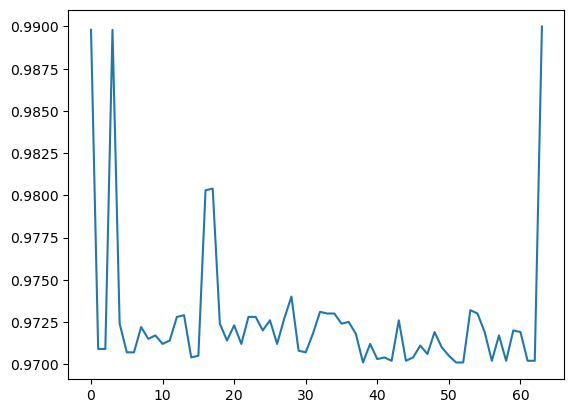

In [49]:
plt.plot(accuracy)

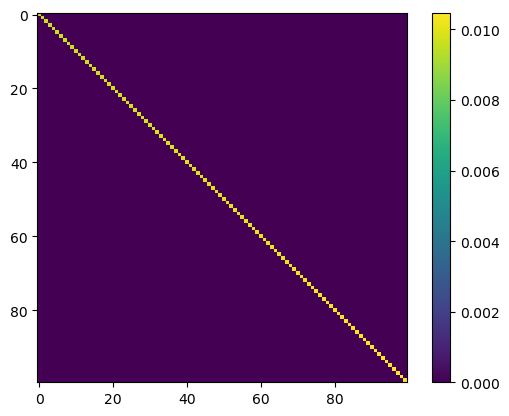

In [50]:
plt.imshow(P_ggw)
plt.colorbar()

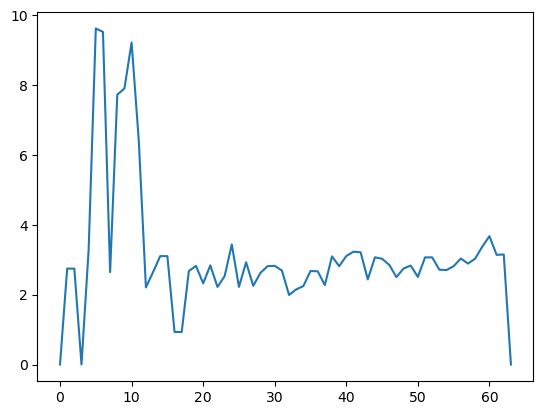

In [51]:
plt.plot(logs["obj_cache"])

In [52]:
obj = compute_gw(P_ggw, C1, C2, "vectorized")
obj

np.float64(0.00017804013489808312)

Text(0.5, 1.0, 'Local | min=1.78e-04 | err=2.45e-03')

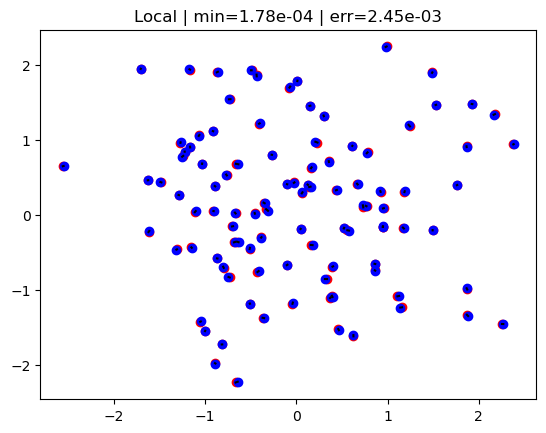

In [53]:
plt.plot(X[:, 0], X[:, 1], "ro")
plt.plot(Y[:, 0], Y[:, 1], "bo")

for i, j in it.product(range(n), range(n)):
    if P_ggw[i, j] > 1e-6:
        plt.plot([X[i, 0], Y[j, 0]], [X[i, 1], Y[j, 1]], "k-")

plt.title("Local | min={:1.2e} | err={:1.2e}".format(obj, rel_error(obj, gt)))

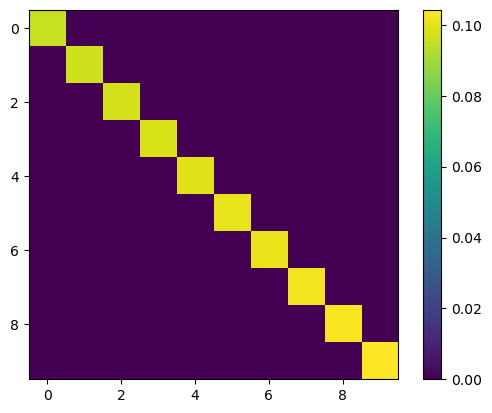

In [98]:
plt.imshow(P_ggw)
plt.colorbar()

# benchmark runtime 

In [2]:
ns_unique = [10, 100, 500, 1000, 3000]
local_ts = []
global_ts = []
ns = []
for n in ns_unique:
    C1, C2, p, q, X, Y = generate_sample_preturb(n=n, scale=0.01, dim=2)
    # Example: Timing a list comprehension
    local_t = %timeit -o gromov_wasserstein(C1, C2, p=p, q=q, loss_fun='square_loss', symmetric=True, log=False, max_iter=1e4, tol_rel=1e-9, tol_abs=1e-9, verbose=False)
    global_t = %timeit -o  gw_global(X,Y,epsilon=1e-6,verbose=False,IterMax=1000,log=False)
    local_ts.extend(local_t.all_runs)
    global_ts.extend(global_t.all_runs)
    ns.extend([n] * len(local_t.all_runs))

363 μs ± 1.95 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Iter |Bound gap
----------------------
    0|8.166088e+02
    1|7.843524e+02
    2|7.812319e+02
    3|7.786239e+02
    4|5.705538e+02
    5|5.557297e+02
    6|5.531217e+02
    7|5.500012e+02
    8|5.177448e+02
    9|4.586197e+02
   10|3.162513e+02
   11|3.052670e+02
   12|1.096416e+02
   13|1.019018e+02
   14|9.746665e+01
   15|8.590510e+01
   16|7.275143e+01
   17|6.293785e+01
   18|8.025625e-03
   19|0.000000e+00
Iter |Bound gap
----------------------
    0|8.166088e+02
    1|7.843524e+02
    2|7.812319e+02
    3|7.786239e+02
    4|5.705538e+02
    5|5.557297e+02
    6|5.531217e+02
    7|5.500012e+02
    8|5.177448e+02
    9|4.586197e+02
   10|3.162513e+02
   11|3.052670e+02
   12|1.096416e+02
   13|1.019018e+02
   14|9.746665e+01
   15|8.590510e+01
   16|7.275143e+01
   17|6.293785e+01
   18|8.025625e-03
   19|0.000000e+00
Iter |Bound gap
----------------------
    0|8.166088e+02
    1|7.843524e+02
    2|7.8123

/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


9.99 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Iter |Bound gap
----------------------


/mnt/home/gwoollard/software/mambaforge/envs/cryo_challenge/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


    0|7.389957e+07
    1|7.383806e+07
    2|7.383209e+07
    3|7.383177e+07
    4|6.909583e+07
    5|6.906524e+07
    6|6.906492e+07
    7|6.905895e+07
    8|6.899744e+07
    9|6.552707e+07
   10|6.416176e+07
   11|6.410047e+07
   12|6.399168e+07
   13|6.395505e+07
   14|6.391032e+07
   15|6.323307e+07
   16|1.244579e+07
   17|1.244076e+07
   18|1.243275e+07
   19|1.202190e+07
   20|1.197840e+07
   21|1.195186e+07
   22|1.193504e+07
   23|1.178860e+07
   24|1.175849e+07
   25|1.174686e+07
   26|1.160398e+07
   27|1.159754e+07
   28|1.158706e+07
   29|1.150557e+07
   30|1.140415e+07
   31|1.137658e+07
   32|1.130982e+07
   33|1.129382e+07
   34|1.127622e+07
   35|1.123407e+07
   36|1.119013e+07
   37|1.118600e+07
   38|1.117315e+07
   39|1.115623e+07
   40|1.113665e+07
   41|1.113100e+07
   42|1.112293e+07
   43|1.111032e+07
   44|1.108928e+07
   45|1.107151e+07
   46|1.106309e+07
   47|1.104601e+07
   48|1.102601e+07
   49|1.102341e+07
   50|1.102085e+07
   51|1.101484e+07
   52|1.0991

<Axes: xlabel='n'>

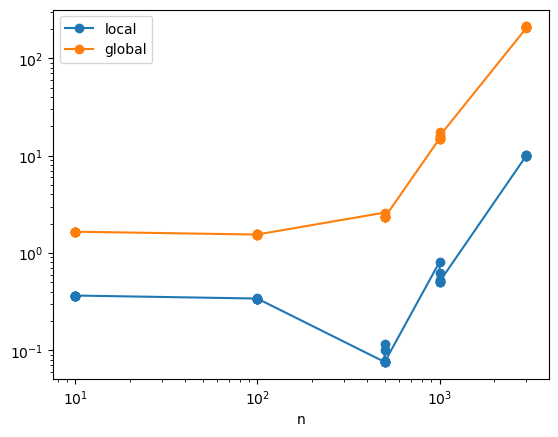

In [11]:
df = pd.DataFrame({"n": ns, "global": global_ts, "local": local_ts})
df.plot(
    x="n",
    y=[
        "local",
        "global",
    ],
    kind="line",
    marker="o",
    logx=True,
    logy=True,
)